In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

#### Q1

In [2]:
banknotes = pd.read_csv('data_banknote_authentication.csv')

In [3]:
banknotes['class'].value_counts()

class
0    762
1    610
Name: count, dtype: int64

In [4]:
banknotes['Color'] = ['Green' if c == 0 else 'Red'
                     for c in banknotes['class']]

In [5]:
banknotes.columns

Index(['variance', 'skewness', 'curtosis', 'entropy', 'class', 'Color'], dtype='object')

In [6]:
features = ['variance', 'skewness', 'curtosis', 'entropy']

In [7]:
group_by_class = banknotes.groupby(by='class')[features]
functions = ['mean','std']
summary_data = pd.concat([group_by_class.agg(functions).round(2),pd.DataFrame(banknotes[features].agg(functions).unstack()).T],axis=0)
summary_data.index = [0,1,'all']
summary_data.round(2)

variance       skewness       curtosis       entropy      
        mean   std     mean   std     mean   std    mean   std
0       2.28  2.02     4.26  5.14     0.80  3.24   -1.15  2.13
1      -1.87  1.88    -0.99  5.40     2.15  5.26   -1.25  2.07
all     0.43  2.84     1.92  5.87     1.40  4.31   -1.19  2.10

#### Q2

##### 1. split your dataset X into training Xtrain and Xtesting parts (50/50 split). Using ”pairplot” from seaborn package, plot pairwise relationships in Xtrain separately for class 0 and class 1. Save your results into 2 pdf files ”good bills.pdf” and ”fake bills.pdf”

In [8]:
X_train, X_test = train_test_split(banknotes, test_size=.5, stratify=banknotes.Color)

In [9]:
X_train.Color.value_counts(normalize=True)

Color
Green    0.555394
Red      0.444606
Name: proportion, dtype: float64

In [10]:
[X_train.Color=='Green']

[565      True
 1295    False
 1093    False
 699      True
 494      True
         ...  
 217      True
 993     False
 1006    False
 964     False
 1223    False
 Name: Color, Length: 686, dtype: bool]

In [11]:
hue = X_train.Color

In [12]:
plt.set_cmap('Greens')


<Figure size 640x480 with 0 Axes>

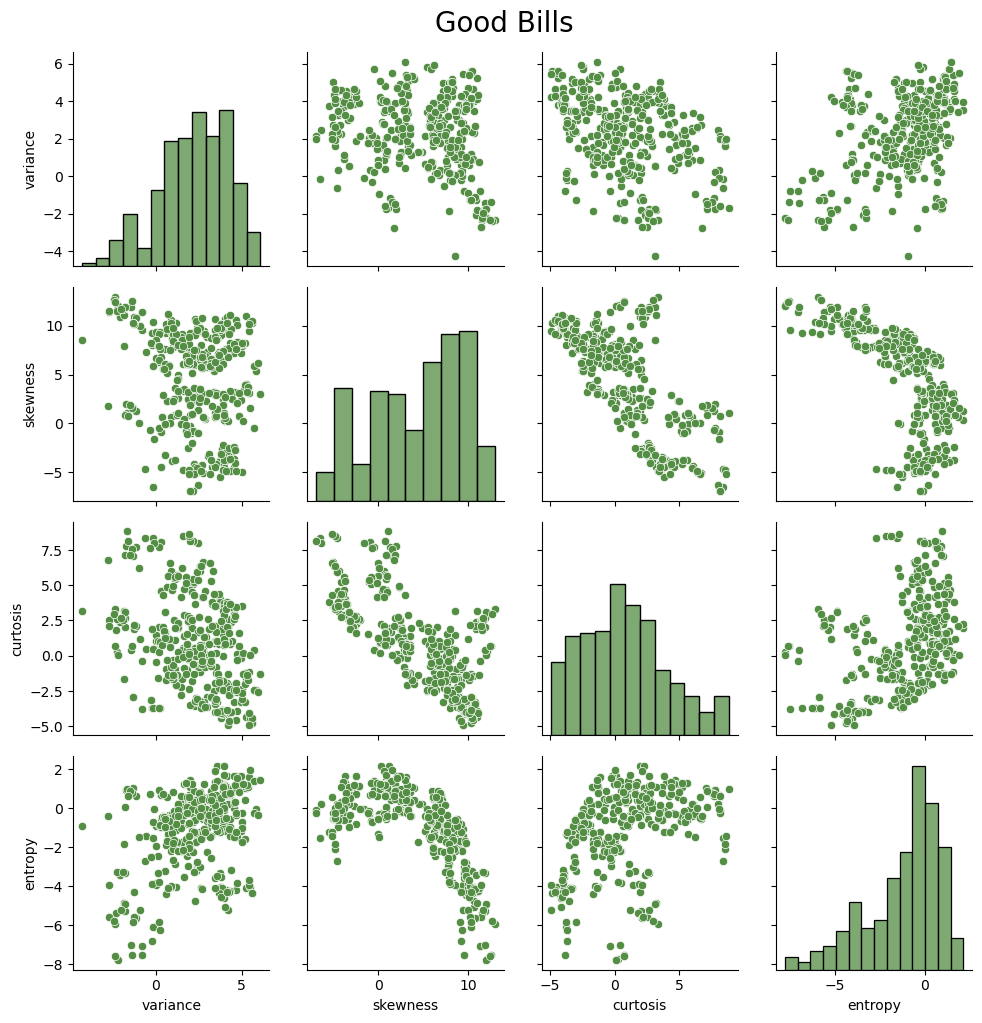

In [13]:

g = sns.PairGrid(X_train[X_train.Color=='Green'][features])
color = sns.xkcd_rgb['fern green']
g.map_upper(sns.scatterplot,c=color)
g.map_diag(sns.histplot, color = color)
g.map_lower(sns.scatterplot,c=color)
g.fig.suptitle("Good Bills",y=1.02,fontsize=20);
g.savefig("./good_bills.pdf")

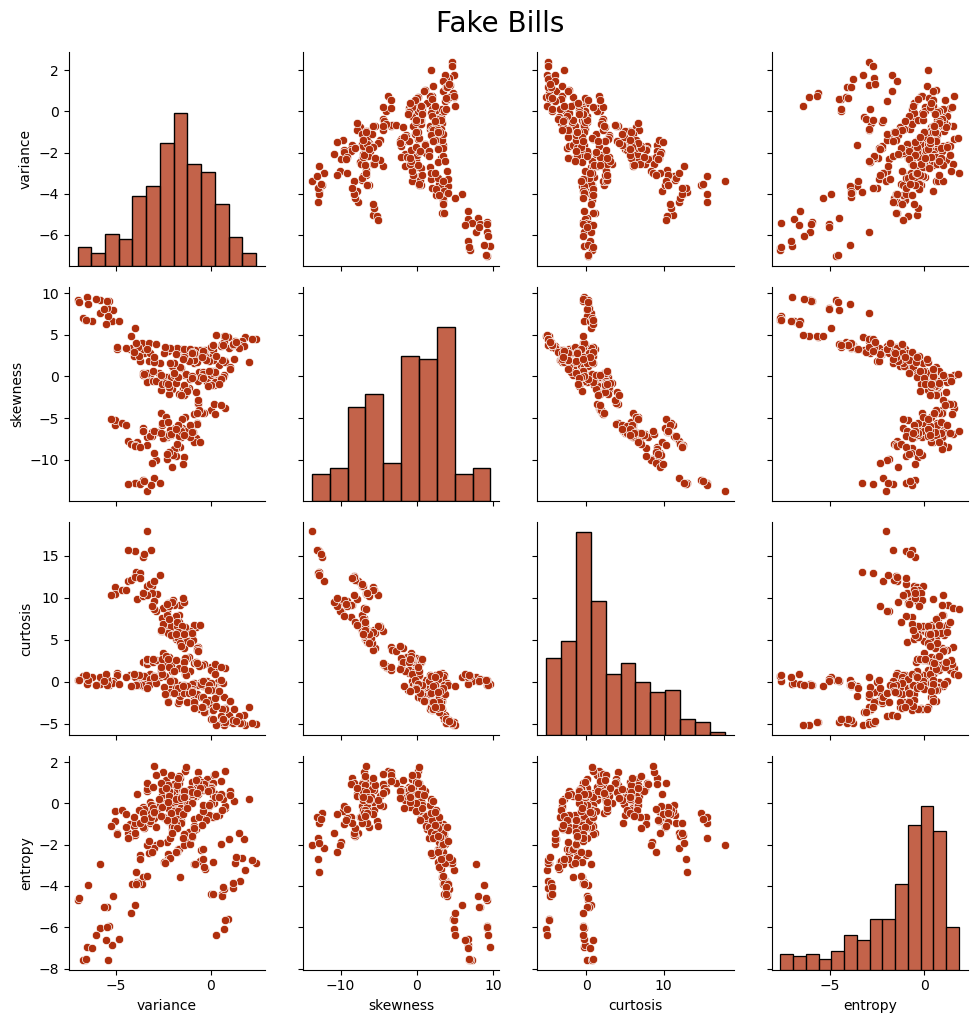

In [14]:
g = sns.PairGrid(X_train[X_train.Color=='Red'][features])
color = sns.xkcd_rgb['rusty red']
g.map_upper(sns.scatterplot,c=color)
g.map_diag(sns.histplot, color = color)
g.map_lower(sns.scatterplot,c=color)
g.fig.suptitle("Fake Bills",y=1.02,fontsize=20);
g.savefig("./fake_bills.pdf")

After visual inspection I will use the following rules for differentiating good and bad banknotes: 

In [15]:
features = features + ['Color']

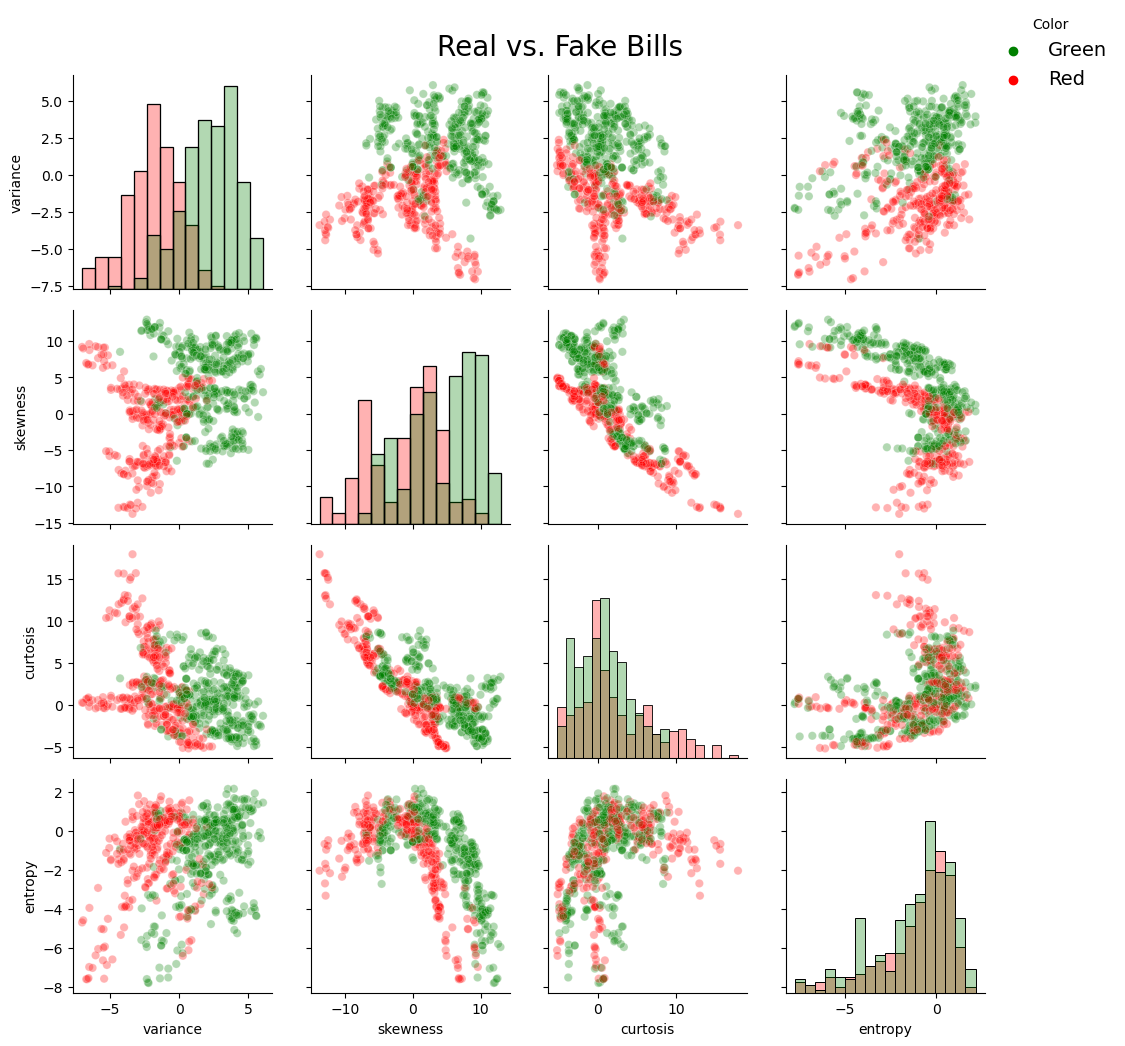

In [16]:
g = sns.PairGrid(X_train[features],hue = 'Color',palette={'Green':'Green','Red':'Red'})
g.map_upper(sns.scatterplot,alpha=.3)
g.map_diag(sns.histplot, alpha=.3)
g.map_lower(sns.scatterplot, alpha=.3)
g.fig.suptitle("Real vs. Fake Bills",y=1.02,fontsize=20);
g.savefig("./real_fake.pdf")
g.add_legend(fontsize=14, bbox_to_anchor=(1,1))

Q2 part 3

In [17]:
# I did not believe there was a third comparison that was useful.
def simple_classifier(variance, skewness):
    '''classifier based on visual inspection
    arg: row of dataframe or series
    return: label, "Good" or "Fake" '''
    if (variance < 2) and (skewness <3):
        return "Fake"
    else:
        return "Good"

In [18]:
simple_preds = X_test.apply(lambda x: simple_classifier(x['variance'], x['skewness']), 
             axis = 1)

Q3 part 4

In [19]:
X_test['class']

570     0
202     0
877     1
1080    1
404     0
       ..
65      0
709     0
610     0
1086    1
278     0
Name: class, Length: 686, dtype: int64

In [20]:
simple_results = pd.DataFrame({'Predicted_Class' : 
              simple_preds.apply(lambda x: 0 if x == 'Good' else 1),
              'True_Class':X_test['class']})

In [21]:
simple_results

,Predicted_Class,True_Class
570,0,0
202,0,0
877,1,1
1080,0,1
404,1,0
...,...,...
65,0,0
709,0,0
610,0,0
1086,1,1


In [22]:
def cm_result(p,t):
    if (p == 1) and (t == 1):
        return 'TP'
    elif (p == 1) and (t == 0):
        return 'FP'
    elif (p == 0) and (t == 0):
        return 'TN'
    elif (p == 0) and (t == 1):
        return 'FN'
    else:
        return 'Invalid entry'

In [23]:
simple_results['CM_Result'] = simple_results.apply(
    lambda x: cm_result(x['Predicted_Class'], x['True_Class']),axis=1)

In [24]:
simple_results

,Predicted_Class,True_Class,CM_Result
570,0,0,TN
202,0,0,TN
877,1,1,TP
1080,0,1,FN
404,1,0,FP
...,...,...,...
65,0,0,TN
709,0,0,TN
610,0,0,TN
1086,1,1,TP


True Positives:

In [25]:
cm_stats = simple_results['CM_Result'].value_counts()

In [26]:
cm_stats['TPR'] = cm_stats['TP']/(cm_stats['TP']+cm_stats['FN'])
cm_stats['TNR'] = cm_stats['TN']/(cm_stats['TN']+cm_stats['FP'])

In [27]:
cm_stats['accuracy'] = (cm_stats['TP']+cm_stats['TN'])/(
                        cm_stats['TP']+cm_stats['TN'] + \
                        cm_stats['FP']+cm_stats['FN'])

Q2 Part 5:

In [28]:
fidnings_summary = pd.DataFrame(cm_stats).T.round(2)
fidnings_summary.index = ['Value']
fidnings_summary

CM_Result,TN,TP,FN,FP,TPR,TNR,accuracy
Value,331.0,212.0,93.0,50.0,0.7,0.87,0.79


The accuracy is much better than p=.5 random coin flipping in terms of overall accuracy but also TPR and TNR.  True Negative rate is still better than true positive rate.

##### Question 3

In [29]:
knn = KNeighborsClassifier()

In [30]:
banknotes

,variance,skewness,curtosis,entropy,class,Color
0,3.62160,8.66610,-2.8073,-0.44699,0,Green
1,4.54590,8.16740,-2.4586,-1.46210,0,Green
2,3.86600,-2.63830,1.9242,0.10645,0,Green
3,3.45660,9.52280,-4.0112,-3.59440,0,Green
4,0.32924,-4.45520,4.5718,-0.98880,0,Green
...,...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1,Red
1368,-1.38870,-4.87730,6.4774,0.34179,1,Red
1369,-3.75030,-13.45860,17.5932,-2.77710,1,Red
1370,-3.56370,-8.38270,12.3930,-1.28230,1,Red


In [31]:
features = ['variance', 'skewness', 'curtosis', 'entropy']
accuracies = {}
scaler = StandardScaler()
for k in range(3,12,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    X_train, X_test = train_test_split(banknotes, stratify = banknotes['class'],
                        test_size=.5, random_state=987654321)
    y_train = X_train.pop('class')
    y_test = X_test.pop('class')
    scaler.fit(X_train[features])
    X_train = scaler.transform(X_train[features])
    X_test = scaler.transform(X_test[features])
    knn.fit(X_train,y_train)
    predictions = knn.predict(X_test)
    accuracies[k] = knn.score(X_test,y_test)
    # sum(predictions==X_test['class'])/len(X_test['class'])

In [32]:
accuracies

{3: 0.9985422740524781,
 5: 0.9985422740524781,
 7: 0.9956268221574344,
 9: 0.9912536443148688,
 11: 0.9883381924198251}

[Text(0.5, 1.0, 'KNN Accuracy by K'),
 Text(0.5, 0, 'K Value'),
 Text(0, 0.5, 'Accuracy')]

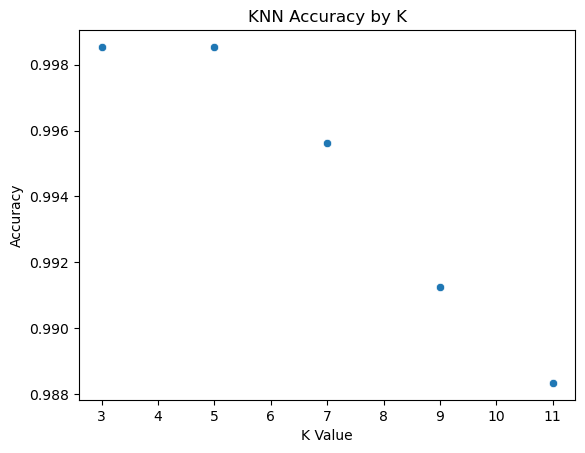

In [33]:
g = sns.scatterplot(x=range(3,12,2),y=[accuracies[k] for k in range(3,12,2)])
g.set(title= "KNN Accuracy by K",xlabel='K Value',ylabel='Accuracy')

In [34]:
accuracies

{3: 0.9985422740524781,
 5: 0.9985422740524781,
 7: 0.9956268221574344,
 9: 0.9912536443148688,
 11: 0.9883381924198251}

All number of neighbors result in accuracies close to if not exactly one.  However, it should be noted that changing the seed, or altering the train-test split samples, has an affect on these results so it is not clear that one k is better than another even if the random state resulting in the above metrics indicates a k less than or equal to 5 is ideal.

In [35]:
features = ['variance', 'skewness', 'curtosis', 'entropy']
accuracies = {}
scaler = StandardScaler()
for k in range(3,12,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    X_train, X_test = train_test_split(banknotes, stratify = banknotes['class'],
                        test_size=.5, random_state=987654321)
    y_train = X_train.pop('class')
    y_test = X_test.pop('class')
    scaler.fit(X_train[features])
    X_train = scaler.transform(X_train[features])
    X_test = scaler.transform(X_test[features])
    knn.fit(X_train,y_train)
    predictions = knn.predict(X_test)
    accuracies[k] = knn.score(X_test,y_test)
    # sum(predictions==X_test['class'])/len(X_test['class'])

In [36]:
X = banknotes

In [37]:
knn = KNeighborsClassifier(n_neighbors=5)
X_train, X_test = train_test_split(X,stratify = X['class'],test_size=.5,
                        random_state=987654321)

In [38]:
X_train = X_train.drop('Color', axis=1)
X_test = X_test.drop('Color', axis=1)

In [39]:
y_train = X_train.pop('class')
y_test = X_test.pop('class')
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)

cm = confusion_matrix(y_test,predictions)
stats = pd.DataFrame(pd.Series({'TP':cm[1,1], 'FP':cm[1,0],'TN':cm[0,0],'FN':cm[0,1], 
          'accuracy': knn.score(X_test,y_test),
          'TPR':cm[1,1]/(cm[1,1]+cm[0,1]), 'TNR':cm[0,0]/(cm[0,0]+cm[1,0])})).T
stats.index = ['Metric Value']
stats

,TP,FP,TN,FN,accuracy,TPR,TNR
Metric Value,305.0,0.0,380.0,1.0,0.998542,0.996732,1.0


Knn does much better than my simple classifier, and is perfect.

In [40]:
# last 4 digits of BU ID: 3334.
simple_classifier(3,3)

'Good'

In [41]:
features

['variance', 'skewness', 'curtosis', 'entropy']

pd.DataFrame(dict(zip(features,[3,3,3,4])),index= ['BUID'])

knn.predict(pd.concat([X_test[features],
pd.DataFrame(dict(zip(features,[3,3,3,4])),index= ['BUID'])]))[-1]

Both my simple classifier and the knn classifier predict a 'Good' or class 0 banknote

Question 4:

In [45]:
np.array(features)

array(['variance', 'skewness', 'curtosis', 'entropy'], dtype='<U8')

In [46]:
features.index('skewness')

1

In [47]:
features = np.array(features)

In [50]:
features = np.array(features)
stats_drop_f = pd.DataFrame()
for i in range(0,4):
    drop_feature = features[i]
    remaining_features = features[features!=drop_feature]
    
    knn = KNeighborsClassifier(n_neighbors=5)
    X_train, X_test = train_test_split(X, stratify = X['class'],test_size=.5,
                            random_state=987654321)
    y_train = X_train.pop('class')
    y_test = X_test.pop('class')
    scaler.fit(X_train[remaining_features])
    X_train = scaler.transform(X_train[remaining_features])
    X_test = scaler.transform(X_test[remaining_features])
    
    knn.fit(X_train,y_train)
    predictions = knn.predict(X_test)
    cm = confusion_matrix(y_test,predictions)
    stats = pd.DataFrame(pd.Series({'TP':cm[1,1], 'FP':cm[1,0],'TN':cm[0,0],'FN':cm[0,1], 
              'accuracy': knn.score(X_test,y_test),
              'TPR':cm[1,1]/(cm[1,1]+cm[0,1]), 'TNR':cm[0,0]/(cm[0,0]+cm[1,0])})).T
    stats.index = [drop_feature]
    stats_drop_f = pd.concat([stats_drop_f,stats],axis=0)    

In [51]:

    knn = KNeighborsClassifier(n_neighbors=5)
    X_train, X_test = train_test_split(X,stratify = X['class'],test_size=.5,
                            random_state=987654321)
    
    y_train = X_train.pop('class')
    y_test = X_test.pop('class')
    scaler.fit(X_train[features])
    X_train = scaler.transform(X_train[features])
    X_test = scaler.transform(X_test[features])
    
    knn.fit(X_train,y_train)
    predictions = knn.predict(X_test)
    cm = confusion_matrix(y_test,predictions)
    stats = pd.DataFrame(pd.Series({'TP':cm[1,1], 'FP':cm[1,0],'TN':cm[0,0],'FN':cm[0,1], 
              'accuracy': knn.score(X_test,y_test),
              'TPR':cm[1,1]/(cm[1,1]+cm[0,1]), 'TNR':cm[0,0]/(cm[0,0]+cm[1,0])})).T
    stats.index = ['Full_Model']
    stats_drop_f = pd.concat([stats_drop_f,stats],axis=0)

In [52]:
stats_drop_f.index.name = 'DroppedFeature'

In [53]:
stats_drop_f

,TP,FP,TN,FN,accuracy,TPR,TNR
DroppedFeature,,,,,,,
variance,286.0,19.0,367.0,14.0,0.951895,0.953333,0.950777
skewness,299.0,6.0,367.0,14.0,0.970845,0.955272,0.983914
curtosis,293.0,12.0,376.0,5.0,0.975219,0.983221,0.969072
entropy,301.0,4.0,380.0,1.0,0.992711,0.996689,0.989583
Full_Model,305.0,0.0,380.0,1.0,0.998542,0.996732,1.000000


Knn feature significance ordering: variance > skewness > curtosis > entropy

Removing variance has the most detrimental impact on accuracy, while removing entropy had the least effect.

##### Question 5 Logistic Regression

In [54]:
X

,variance,skewness,curtosis,entropy,class,Color
0,3.62160,8.66610,-2.8073,-0.44699,0,Green
1,4.54590,8.16740,-2.4586,-1.46210,0,Green
2,3.86600,-2.63830,1.9242,0.10645,0,Green
3,3.45660,9.52280,-4.0112,-3.59440,0,Green
4,0.32924,-4.45520,4.5718,-0.98880,0,Green
...,...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1,Red
1368,-1.38870,-4.87730,6.4774,0.34179,1,Red
1369,-3.75030,-13.45860,17.5932,-2.77710,1,Red
1370,-3.56370,-8.38270,12.3930,-1.28230,1,Red


In [55]:
features

array(['variance', 'skewness', 'curtosis', 'entropy'], dtype='<U8')

In [56]:
X = banknotes
X_train,X_test = train_test_split(X,random_state=987654321,stratify=X['class'],
                                 test_size=.5)

lr = LogisticRegression()
lr.fit(X_train[features], X_train['class'])
lr.score(X_test[features],X_test['class'])

0.9912536443148688

In [57]:
predictions = lr.predict(X_test[features])
cm = confusion_matrix(X_test['class'],predictions)
stats = pd.DataFrame(pd.Series({'TP':cm[1,1], 'FP':cm[1,0],'TN':cm[0,0],'FN':cm[0,1], 
          'accuracy': lr.score(X_test[features],X_test['class']),
          'TPR':cm[1,1]/(cm[1,1]+cm[0,1]), 'TNR':cm[0,0]/(cm[0,0]+cm[1,0])})).T
stats.index = ['LogReg Metrics']

In [58]:
stats

,TP,FP,TN,FN,accuracy,TPR,TNR
LogReg Metrics,305.0,0.0,375.0,6.0,0.991254,0.980707,1.0


The logreg classifier is much better than my simple classifier for all measures.

However, it is not better than the most accurate knn model, which achieved perfect accuracy and thus perfect TRP and TNR.


In [59]:
lr.predict(np.array([3,3,3,4]).reshape(1, -1))

/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0])

Logistic regression also predicts a "Good" bill based on the last 4 digits of my BUID.

Question 6:  

In [60]:
features = np.array(features)
stats_drop_f = pd.DataFrame()
for i in range(0,4):
    drop_feature = features[i]
    remaining_features = features[features!=drop_feature]
    lr = LogisticRegression()
    X_train, X_test = train_test_split(X,stratify = X['class'],test_size=.5,
                            random_state=987654321)
    lr.fit(X_train[remaining_features],X_train['class'])
    predictions = lr.predict(X_test[remaining_features])
    cm = confusion_matrix(X_test['class'],predictions)
    stats = pd.DataFrame(pd.Series({'TP':cm[1,1], 'FP':cm[1,0],'TN':cm[0,0],'FN':cm[0,1], 
              'accuracy': lr.score(X_test[remaining_features],X_test['class']),
              'TPR':cm[1,1]/(cm[1,1]+cm[0,1]), 'TNR':cm[0,0]/(cm[0,0]+cm[1,0])})).T
    stats.index = [drop_feature]
    stats_drop_f = pd.concat([stats_drop_f,stats],axis=0)
    
lr = LogisticRegression()
X_train, X_test = train_test_split(X,stratify = X['class'],test_size=.5,
                        random_state=987654321)
lr.fit(X_train[features],X_train['class'])
predictions = lr.predict(X_test[features])
cm = confusion_matrix(X_test['class'],predictions)
stats = pd.DataFrame(pd.Series({'TP':cm[1,1], 'FP':cm[1,0],'TN':cm[0,0],'FN':cm[0,1], 
          'accuracy': lr.score(X_test[features],X_test['class']),
          'TPR':cm[1,1]/(cm[1,1]+cm[0,1]), 'TNR':cm[0,0]/(cm[0,0]+cm[1,0])})).T
stats.index = ['Full_Model']
stats_drop_f = pd.concat([stats_drop_f,stats],axis=0)

In [61]:
stats_drop_f

,TP,FP,TN,FN,accuracy,TPR,TNR
variance,253.0,52.0,300.0,81.0,0.806122,0.757485,0.852273
skewness,267.0,38.0,354.0,27.0,0.905248,0.908163,0.903061
curtosis,246.0,59.0,355.0,26.0,0.876093,0.904412,0.857488
entropy,305.0,0.0,375.0,6.0,0.991254,0.980707,1.000000
Full_Model,305.0,0.0,375.0,6.0,0.991254,0.980707,1.000000


Accuracy increased slightly when entropy was dropped, decreased the most when variance was dropped, and decreased the least when skewness was dropped

Knn feature significance ordering: variance > skewness > curtosis > entropy
LogReg feature significance ordering: variance > curtosis > skewness > entropy